In [1]:
#Data for United Kingdom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import seaborn as sns

In [2]:
data = pd.read_csv('dataretail.csv')
print(data.shape)
data.head()
data_upt = data

(541909, 8)


In [3]:
data_upt[['CustomerID', 'Country']].drop_duplicates()
data_upt.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending = False)
data_upt = data_upt.loc[data_upt['Country'] == 'United Kingdom']
data_upt.isnull().sum(axis = 0)
data_upt = data_upt[pd.notnull(data_upt['CustomerID'])]
data_upt.isnull().sum(axis = 0)
data_upt = data_upt[(data_upt['Quantity']>0)]
data_upt['TotalPrice'] = data_upt['Quantity'] * data_upt['UnitPrice']
data_upt['InvoiceDate'] = pd.to_datetime(data_upt['InvoiceDate'])

In [4]:
#Split Date column space



#data_upt['InvDate'], data_upt['InvTime'] = data_upt['InvoiceDate'].split(' ', 1)

#Date Conversion
#import datetime as dt
#dateDF = dt.datetime['InvoiceDate']
#todDate = dt.date.today()
#print(todDate)

#Adding a column for delta of dates
#type(data_upt['InvoiceDate']





      






In [5]:
#Standardizing the Data
features = ['StockCode', 'Quantity', 'UnitPrice']
x = data_upt.loc[:, features].values

y = data_upt.loc[:, ['CustomerID']].values

x = StandardScaler().fit_transform(x)
pd.DataFrame(data_upt, columns = features).head()

#Setting up data for PCA
pca_data = data_upt
pca_calc = pca_data[['StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice']]
pca_calc.head()
#TEST copy of pca data
pca_calc_copy = pca_calc
pca_calc_copy = pca_calc[['StockCode', 'Quantity', 'UnitPrice']]
pca_calc_copy.head()


,StockCode,Quantity,UnitPrice
0,1,6,2.55
1,1,6,3.39
2,2,8,2.75
3,2,6,3.39
4,6,6,3.39


In [6]:
#Principle Component Analysis
pca = PCA(n_components = 2)
prinComps = pca.fit_transform(x)
prinCompDF = pd.DataFrame(data = prinComps, columns = ['PC 1','PC 2'])
prinCompDF.head(5)

,PC 1,PC 2
0,0.023589,1.463625
1,0.056843,1.463921
2,0.017068,0.877490
3,0.049830,0.877472
4,0.021778,-1.468324


In [7]:
import datetime as dt
NOW = dt.datetime(2011,12,31)

In [8]:
#Recency Calculation
rfmTab = data_upt.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': lambda x: len(x), #Frequency
    'TotalPrice': lambda x: x.sum()}) #Monetary Value
rfmTab['InvoiceDate'] = rfmTab['InvoiceDate'].astype(int)
rfmTab.rename(columns = {'InvoiceDate': 'recency',
                        'InvoiceNo': 'frequency',
                        'TotalPrice': 'monetary_value'}, inplace = True)

In [9]:
quantiles = rfmTab.quantile(q = [.25, .50, .75])
quantiles = quantiles.to_dict()
quantiles
#Recency Function
def RScore(x,p,d):
    if x <= d[p][.25]:
        return 1
    elif x <= d[p][.50]:
        return 2
    elif x <= d[p][.75]:
        return 3
    else:
        return 4

def FMScore(x,p,d):
    if x <= d[p][.25]:
        return 4
    elif x <= d[p][.50]:
        return 3
    elif x <= d[p][.75]:
        return 2
    else:
        return 1
seg_rfm = rfmTab
seg_rfm['r_quartile'] = seg_rfm['recency'].apply(RScore, args=('recency', quantiles,))
seg_rfm['f_quartile'] = seg_rfm['frequency'].apply(FMScore, args=('frequency', quantiles,))
seg_rfm['m_quartile'] = seg_rfm['monetary_value'].apply(FMScore, args=('monetary_value', quantiles,))
seg_rfm['RFMScore'] = seg_rfm.r_quartile.map(str) + seg_rfm.f_quartile.map(str) + seg_rfm.m_quartile.map(str)
seg_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12346.0,346,1,77183.60,4,4,1,441
12747.0,43,103,4196.01,2,1,1,211
12748.0,25,4596,33719.73,1,1,1,111
12749.0,43,199,4090.88,2,1,1,211
12820.0,65,59,942.34,2,2,2,222


In [10]:
a = seg_rfm[seg_rfm['RFMScore'] == '111'].sort_values('monetary_value', ascending = False)
a_upt = data_upt[data_upt.CustomerID.isin(a.index)]
b = seg_rfm[seg_rfm['RFMScore'] == '144'].sort_values('monetary_value', ascending = False)
b_upt = data_upt[data_upt.CustomerID.isin(b.index)]
c = seg_rfm[seg_rfm['RFMScore'] == '441'].sort_values('monetary_value', ascending = False)
c_upt = data_upt[data_upt.CustomerID.isin(c.index)]
d = seg_rfm[seg_rfm['RFMScore'] == '444'].sort_values('monetary_value', ascending = False)
d_upt = data_upt[data_upt.CustomerID.isin(d.index)]

a.head(20)




,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
18102.0,32,431,259657.30,1,1,1,111
17450.0,23,337,194550.79,1,1,1,111
17511.0,26,963,91062.38,1,1,1,111
16684.0,32,277,66653.56,1,1,1,111
14096.0,32,5111,65164.79,1,1,1,111
15311.0,20,2379,60767.90,1,1,1,111
13089.0,26,1818,58825.83,1,1,1,111
15061.0,25,403,54534.14,1,1,1,111
14088.0,31,589,50491.81,1,1,1,111


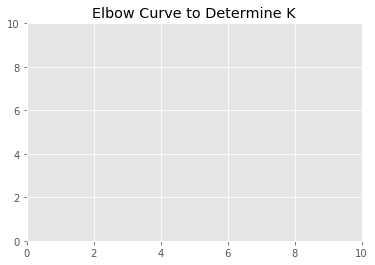

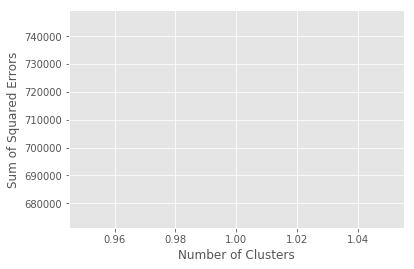

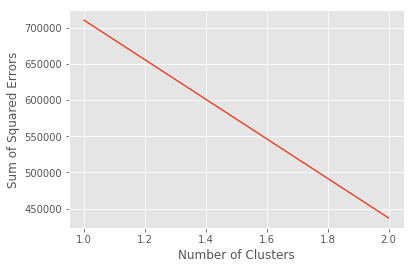

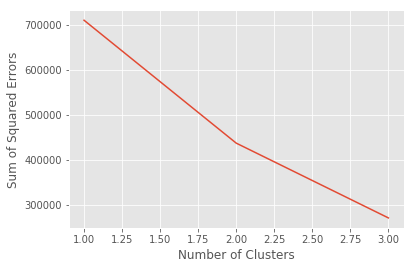

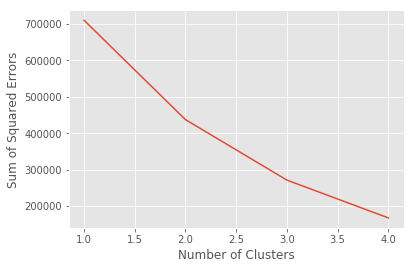

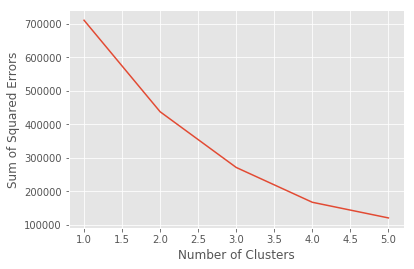

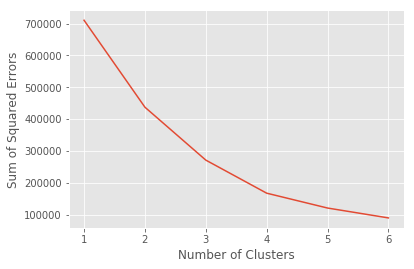

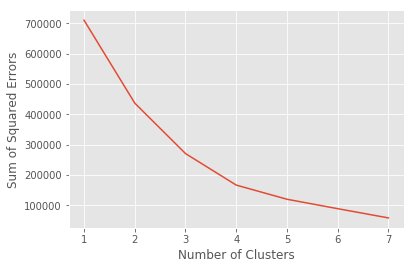

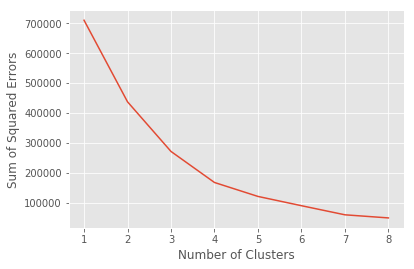

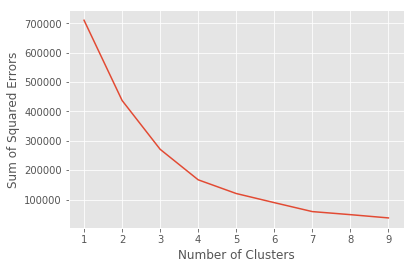

Centroids
 [[-1.56682983e-02 -1.17395222e+00 -2.68141065e-12]
 [-5.86312155e-04  2.91567322e-01  3.00000000e+00]
 [-5.45162671e-03 -2.94995231e-01  5.00000000e+00]
 [ 7.59603919e-03  8.77976454e-01  1.00000000e+00]
 [-2.88121292e+02  9.45400456e+00  2.00000000e+00]
 [ 3.22285361e+02  2.57470291e+00  7.00000000e+00]
 [ 8.01422479e+01  1.00384979e+00  4.85714286e+00]
 [ 1.60670515e-02  1.46440251e+00  1.00000000e+00]
 [ 2.76730894e+01  1.45988561e-01  5.66666667e+00]]
Labels
 [7 7 3 ... 2 0 0]
[[array([-1.4649314 , -0.03176485, -0.02316604]) array([17850.])]
 [array([-1.4649314 , -0.03176485,  0.02386106]) array([17850.])]
 [array([-0.87831286, -0.02126219, -0.01196911]) array([17850.])]
 ...
 [array([ 0.29492421,  0.06275913, -0.09594608]) array([13113.])]
 [array([1.46816128, 0.06275913, 0.33513566]) array([13113.])]
 [array([ 1.46816128, -0.01075952,  0.23044438]) array([13113.])]]


TypeError: 'Series' object cannot be interpreted as an integer

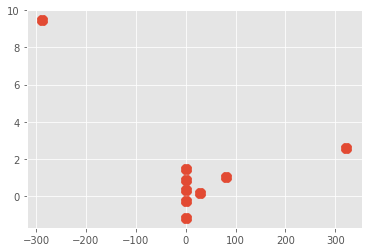

In [11]:
#Elbow Curve for Determining K Clusters
from sklearn import metrics
from scipy.spatial.distance import cdist

numClust = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.plot()
plt.xlim([0,10])
plt.ylim([0,10])
plt.title('Elbow Curve to Determine K')
#plt.scatter(numClust, )
plt.show()

#SSE Calculation

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(prinCompDF)
    prinCompDF['Clusters'] = kmeans.labels_
    #print(prinCompDF['Clusters'])
    sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Errors")
    plt.show()

#According to the Elbow Curve - k = 2

centroids = kmeans.cluster_centers_
print('Centroids\n', centroids)
labels = kmeans.labels_
print('Labels\n', labels)

plt.scatter(centroids[:, 0], centroids[:, 1], marker = "X", linewidths = 5, zorder = 10)

#EUCLIDEAN DISTANCE CALC
def dist(a, b, ax = 1):
    return np.linalg.norm(a - b, axis = ax)

#X coordinates of random centroids
X = np.array(list(zip(x, y)))
print(X)
C_x = np.random.rand(0, np.max(pca_calc_copy)-20)
#Y coordinates of random centroids
C_y = np.random.rand(0, np.max(pca_calc_copy)-20)
C = np.array(list(zip(C_x, C_y)), dtype = np.float32)
print(C)

C_old = np.zeros(C.shape)
plt.scatter(x, y, c = '#050505', s = 7)
plt.scatter(C_x, C_y, marker = '*', s = 200, c = 'g')
    


In [14]:
#Create and Describe dummy conversion columns
cate_conv = pca_data[['Description', 'Country']].copy()
cate_conv.head()
#cate_conv.insert(1, 'Desc Dummy Val', int)
#cate_conv.insert(3, 'Country Dummy Code', int)
#cate_conv.head()


,Description,Country
0,Milk,United Kingdom
1,Milk,United Kingdom
2,Butter,United Kingdom
3,Butter,United Kingdom
4,Paneer,United Kingdom


In [15]:
#Insertion of dummy values
cate_conv_1 = pd.get_dummies(cate_conv['Description'])
cate_conv_2 = pd.get_dummies(cate_conv['Country'])
cate_dummy = pd.concat([cate_conv_1, cate_conv_2], axis = 1)
cate_dummy.head()


,Butter,Cheese,Icecream,Milk,Paneer,Yogurt,United Kingdom
0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,1
2,1,0,0,0,0,0,1
3,1,0,0,0,0,0,1
4,0,0,0,0,1,0,1


In [16]:
#Label Encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cate_conv['Description'])
le.classes_
lab_encode = le.transform(cate_conv['Description'])
#list(le.classes_)
cate_conv['Encoded Val'] = lab_encode
cate_conv

,Description,Country,Encoded Val
0,Milk,United Kingdom,3
1,Milk,United Kingdom,3
2,Butter,United Kingdom,0
3,Butter,United Kingdom,0
4,Paneer,United Kingdom,4
5,Milk,United Kingdom,3
6,Icecream,United Kingdom,2
7,Yogurt,United Kingdom,5
8,Milk,United Kingdom,3
9,Paneer,United Kingdom,4


In [17]:
#Encoding Key
encode_key = cate_conv.copy()
del encode_key['Country']
encode_key.drop_duplicates()
en_key = encode_key.sort_values(by = 'Encoded Val', ascending = True)
en_key.drop_duplicates()


,Description,Encoded Val
463836,Butter,0
369274,Cheese,1
312442,Icecream,2
326411,Milk,3
443300,Paneer,4
61841,Yogurt,5


In [ ]:
data_upt.head()

In [18]:
#Merging categorical conversions with main dataset
pca_calc_copy2 = data_upt.copy()
del pca_calc_copy2['StockCode']
del pca_calc_copy2['InvoiceDate']
del pca_calc_copy2['Description']
del pca_calc_copy2['InvoiceNo']
del pca_calc_copy2['Country']
del pca_calc_copy2['TotalPrice']
pca_calc_A = pd.concat([pca_calc_copy2, cate_conv], axis = 1) #Question about axis
pca_calc_A = pca_calc_A[['CustomerID', 'Description', 'Encoded Val', 'UnitPrice', 'Quantity', 'Country']]
pca_calc_A.head(15)

,CustomerID,Description,Encoded Val,UnitPrice,Quantity,Country
0,17850.0,Milk,3,2.55,6,United Kingdom
1,17850.0,Milk,3,3.39,6,United Kingdom
2,17850.0,Butter,0,2.75,8,United Kingdom
3,17850.0,Butter,0,3.39,6,United Kingdom
4,17850.0,Paneer,4,3.39,6,United Kingdom
5,17850.0,Milk,3,7.65,2,United Kingdom
6,17850.0,Icecream,2,4.25,6,United Kingdom
7,17850.0,Yogurt,5,1.85,6,United Kingdom
8,17850.0,Milk,3,1.85,6,United Kingdom
9,13047.0,Paneer,4,1.69,32,United Kingdom


In [19]:
#Standardizing the Data
features = ['Quantity', 'UnitPrice', 'Butter', 'Cheese', 'Icecream', 'Milk', 'Paneer',
           'Yogurt']
x = pca_calc_A.loc[:, features].values

y = pca_calc_A.loc[:, ['CustomerID']].values

x = StandardScaler().fit_transform(x)
pd.DataFrame(pca_calc_A, columns = features).head()


C:\Users\srohi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [20]:
#Principle Component Analysis
pca = PCA(n_components = 3)
prinComps = pca.fit_transform(x)
prinCompDF = pd.DataFrame(data = prinComps, columns = ['PC 1','PC 2','PC 3'])
prinCompDF.head(5)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

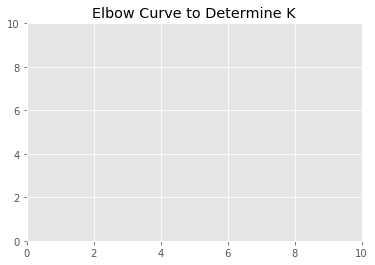

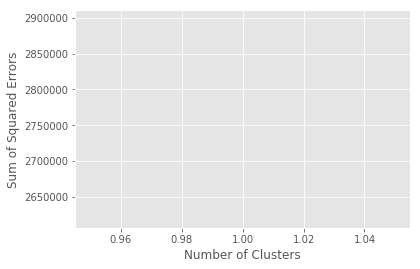

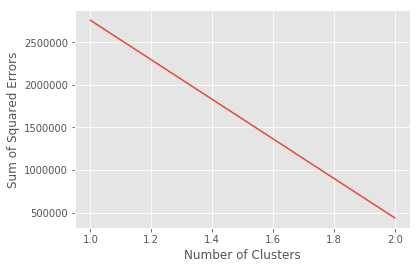

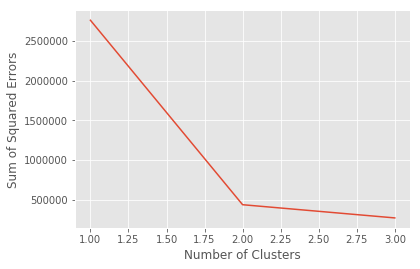

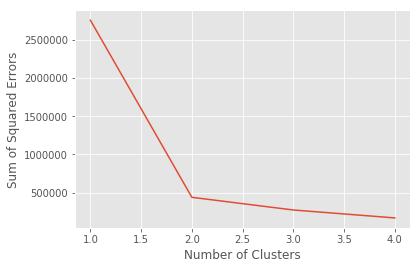

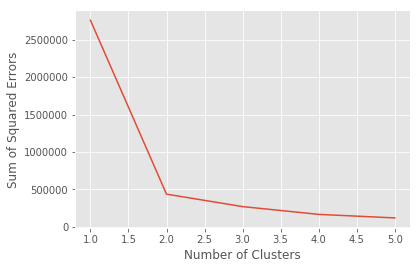

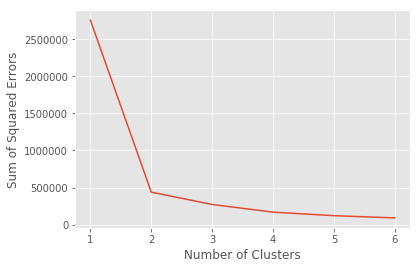

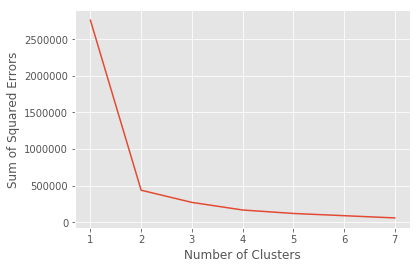

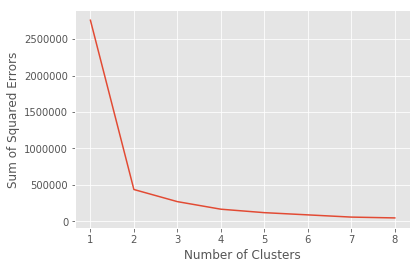

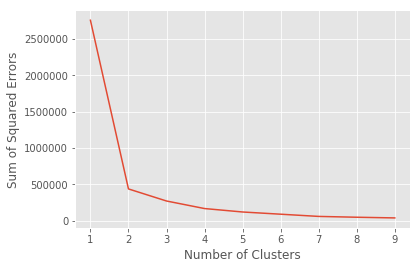

Centroids
 [[ 1.57943464e-02  1.46440141e+00  1.00000000e+00]
 [-3.21252699e-04  2.91540036e-01  5.00003367e+00]
 [-1.60669066e-02 -1.17395803e+00  1.10156329e-12]
 [-4.65992652e-03 -2.95028252e-01  2.00000000e+00]
 [-2.88121292e+02  9.45400456e+00  3.00000000e+00]
 [ 9.45166025e+01  1.27850672e+00  6.00000000e+00]
 [ 3.22285361e+02  2.57470291e+00  4.00000000e+00]
 [ 7.86534389e-03  8.77967674e-01  1.00000000e+00]
 [ 3.32651554e+01  2.93488250e-01  6.85000000e+00]]
Labels
 [0 0 7 ... 3 2 2]
[[array([6.  , 2.55,  nan,  nan,  nan,  nan,  nan,  nan]) array([17850.])]
 [array([6.  , 3.39,  nan,  nan,  nan,  nan,  nan,  nan]) array([17850.])]
 [array([8.  , 2.75,  nan,  nan,  nan,  nan,  nan,  nan]) array([17850.])]
 ...
 [array([24.  ,  1.25,   nan,   nan,   nan,   nan,   nan,   nan])
  array([13113.])]
 [array([24.  ,  8.95,   nan,   nan,   nan,   nan,   nan,   nan])
  array([13113.])]
 [array([10.  ,  7.08,   nan,   nan,   nan,   nan,   nan,   nan])
  array([13113.])]]


TypeError: 'Series' object cannot be interpreted as an integer

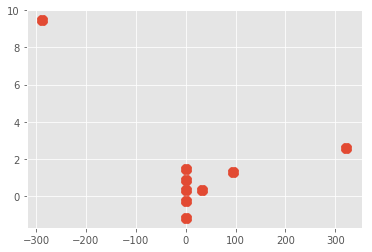

In [21]:
#Elbow Curve for Determining K Clusters
from sklearn import metrics
from scipy.spatial.distance import cdist

numClust = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.plot()
plt.xlim([0,10])
plt.ylim([0,10])
plt.title('Elbow Curve to Determine K')
#plt.scatter(numClust, )
plt.show()

#SSE Calculation

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(prinCompDF)
    prinCompDF['Clusters'] = kmeans.labels_
    #print(prinCompDF['Clusters'])
    sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Errors")
    plt.show()

#According to the Elbow Curve - k = 4

centroids = kmeans.cluster_centers_
print('Centroids\n', centroids)
labels = kmeans.labels_
print('Labels\n', labels)

plt.scatter(centroids[:, 0], centroids[:, 1], marker = "X", linewidths = 5, zorder = 10)

#EUCLIDEAN DISTANCE CALC
def dist(a, b, ax = 1):
    return np.linalg.norm(a - b, axis = ax)

#X coordinates of random centroids
X = np.array(list(zip(x, y)))
print(X)
C_x = np.random.rand(0, np.max(prinCompDF)-20)
#Y coordinates of random centroids
C_y = np.random.rand(0, np.max(prinCompDF)-20)
C = np.array(list(zip(C_x, C_y)), dtype = np.float32)
print(C)

C_old = np.zeros(C.shape)
plt.scatter(x, y, c = '#050505', s = 7)
plt.scatter(C_x, C_y, marker = '*', s = 200, c = 'g')

#Elbow Curve recommends 4 clusters for K-means


    


In [ ]:
n_clusters = 4
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=20)
kmeans.fit(x)
cust_clusters = kmeans.predict(x)
cust_clusters[1:20]

In [22]:
#Add the clusters column to the data
len(cust_clusters)
pca_calc_A['Cluster'] = cust_clusters
#Original Table with Cluster assignments
pca_calc_A



NameError: name 'cust_clusters' is not defined

In [23]:
#Princple Components assigned to respective clusters
prinCompDF['Clusters'] = cust_clusters
cust_clusters.max()

NameError: name 'cust_clusters' is not defined

In [12]:
#Columns grouped by clusters
cluster_view = prinCompDF.sort_values(by = 'Clusters', ascending = True)
cluster_view

,PC 1,PC 2,Clusters
354344,0.153012,-1.466535,0
158167,0.047167,-1.468562,0
328486,0.019209,-1.468966,0
158171,0.010386,-0.882658,0
158172,-0.027806,-1.469075,0
158180,-0.054944,-0.882001,0
158181,-0.054944,-0.882001,0
328482,-0.101846,-1.468495,0
158166,0.054181,-0.882113,0
158187,-0.054944,-0.882001,0


In [ ]:
cluster_view.groupby('Clusters').count()

In [ ]:
def PCA_Metrics():
    print(pca.components_)
    print('Explained Variance Ratio: ', pca.explained_variance_ratio_)
    print('Parameters: ', pca.get_params(deep = True))
    print('Precision: ', pca.get_precision())


In [ ]:
PCA_Metrics()


In [ ]:
print pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2'])


In [ ]:
#Exporting to CSV to produce visualization
cluster_view.to_csv('dataviz.csv')

NOTES
After cleaning the the data and removing categorical and non-numeric variables, I performed PCA to further reduce the dimensionality of the data to 8 variables. I broke down the "Description" column using label encoding values, so that they may be better used in the PCA and k-means algorithm. I decided to use 3 Prinicple Components, as this value is well below the 8 variables we began with, but still high enough to be sufficient. After running an Elbow Curve, I found that 4 clusters would be a good number to use to see the differences in the segmentation. 

INSIGHTS
1. The "Explained Variance Ratio" between the different PCs are very similar, at around .150, showing us that the combination of the varaibles in each component vary in a fairly similar manner. 

2. After using the groupby and count functions to determine the number of customers that were placed into each cluster, I found that there were 59436 people in the first cluster, 176788 in the second cluster, 59170 people in the third cluster, and 58951 in the last cluster. 

3. The variables grouped in the first two Principle Components appear to be positively correlated, while the third appears to show negative correlation.



